In [1]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'vg16_trf_learning.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! unzip -o drive/MyDrive/dataset_19.zip

! pwd

Archive:  drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: data

# Load the data

In [4]:
# Data Directories
dir = "dataset_19/"


## Data Distribution

In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

pituitary     120
notumor       120
meningioma    120
glioma        120
dtype: int64

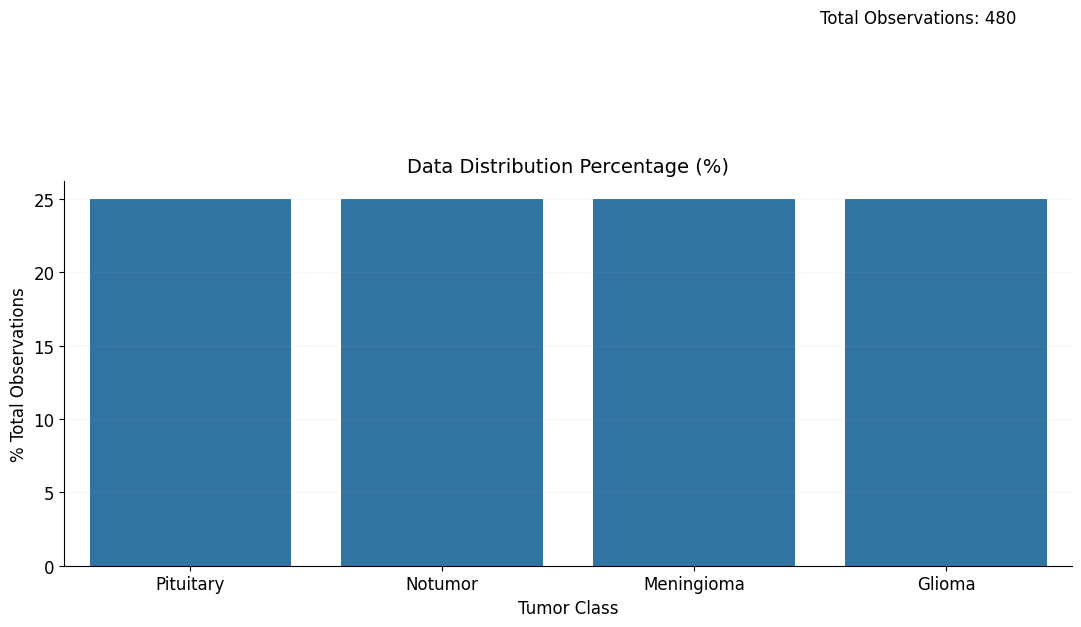

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

## Splitting the data

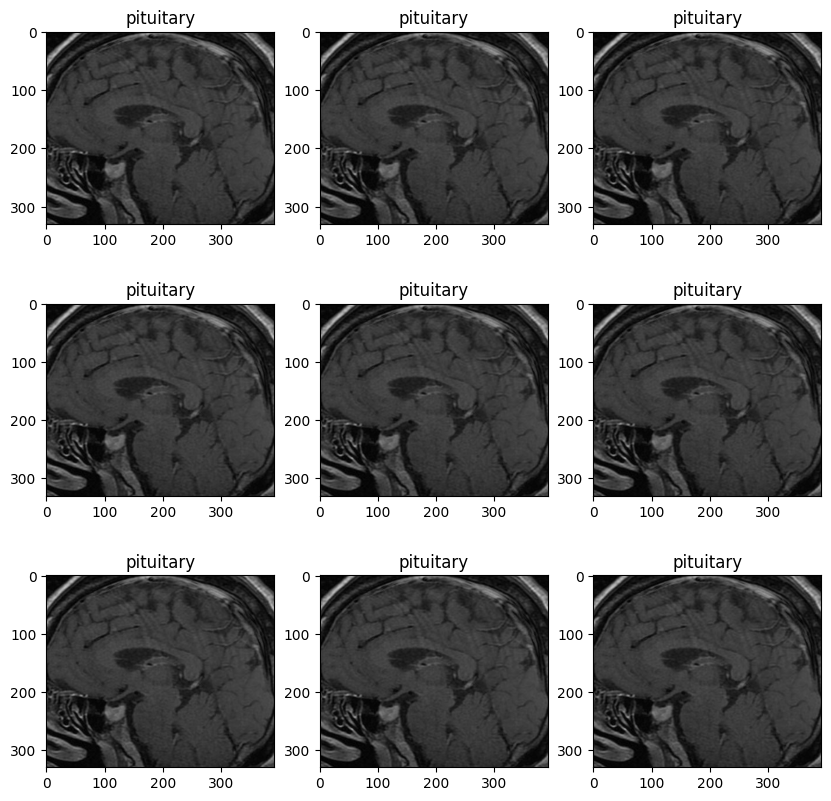

In [5]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

	# Find extreme points on the image and crop the rectangular out

	gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
	gray = cv2.GaussianBlur(gray, (3, 3), 0)

	# threshold the image, then perform a series of erosions +
	# dilations to remove any small regions of noise
	thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
	thresh = cv2.erode(thresh, None, iterations=2)
	thresh = cv2.dilate(thresh, None, iterations=2)

	# find contours in thresholded image, then grab the largest one
	cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)

	# find the extreme points
	extLeft = tuple(c[c[:, :, 0].argmin()][0])
	extRight = tuple(c[c[:, :, 0].argmax()][0])
	extTop = tuple(c[c[:, :, 1].argmin()][0])
	extBot = tuple(c[c[:, :, 1].argmax()][0])
	ADD_PIXELS = 0
	new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

	return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            cv2.imwrite(img_path, cropped_img)

# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break

In [6]:
classes = os.listdir(dir)

batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='validation')


print(test_generator.class_indices)

Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Training a VGG16 model

In [7]:
!pip install optuna optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.5 MB/s eta 0:00:00


In [ ]:
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16
import optuna
from optuna.integration import TFKerasPruningCallback
from keras.callbacks import *

def VGG16_trf_learning(input_shape, num_classes, trial):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Fine-tune last few layers of VGG16
    for layer in base_model.layers[:-4]:
        layer.trainable = False

    x = Flatten()(base_model.output)
    x = Dense(trial.suggest_int('dense_units', 256, 1024), activation='relu')(x)
    x = Dropout(trial.suggest_float('dropout_rate', 0.2, 0.5))(x)
    x = BatchNormalization()(x)

    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)

    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

def objective(trial):
    model = VGG16_trf_learning((224, 224, 3), len(classes), trial)

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
    pruning_callback = TFKerasPruningCallback(trial, 'val_loss')

    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=80,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[early_stopping, reduce_lr, pruning_callback]
    )

    val_loss = min(history.history['val_loss'])
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50, timeout=3600)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-06-05 14:22:35,376] A new study created in memory with name: no-name-58fe6283-0659-436c-bb22-71a2ff27966a
<ipython-input-8-88a44a63551d>:25: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-3)


Epoch 1/80
24/24 [==============================] - 21s 287ms/step - loss: 0.9837 - accuracy: 0.6120 - val_loss: 1.0199 - val_accuracy: 0.6146 - lr: 3.6668e-05
Epoch 2/80
24/24 [==============================] - 6s 226ms/step - loss: 0.4915 - accuracy: 0.8021 - val_loss: 0.8535 - val_accuracy: 0.6458 - lr: 3.6668e-05
Epoch 3/80
24/24 [==============================] - 10s 415ms/step - loss: 0.3224 - accuracy: 0.8750 - val_loss: 0.7854 - val_accuracy: 0.6562 - lr: 3.6668e-05
Epoch 4/80
24/24 [==============================] - 6s 237ms/step - loss: 0.2170 - accuracy: 0.9297 - val_loss: 0.6892 - val_accuracy: 0.7292 - lr: 3.6668e-05
Epoch 5/80
24/24 [==============================] - 6s 258ms/step - loss: 0.1669 - accuracy: 0.9531 - val_loss: 0.6692 - val_accuracy: 0.7604 - lr: 3.6668e-05
Epoch 6/80
24/24 [==============================] - 5s 219ms/step - loss: 0.1330 - accuracy: 0.9635 - val_loss: 0.6265 - val_accuracy: 0.7708 - lr: 3.6668e-05
Epoch 7/80
24/24 [==========================

[I 2024-06-05 14:24:52,335] Trial 0 finished with value: 0.5999574065208435 and parameters: {'dense_units': 665, 'dropout_rate': 0.2789232912960216, 'learning_rate': 3.666750519660056e-05}. Best is trial 0 with value: 0.5999574065208435.


Epoch 1/80
24/24 [==============================] - 9s 235ms/step - loss: 0.9863 - accuracy: 0.6615 - val_loss: 7.2264 - val_accuracy: 0.3333 - lr: 5.1580e-04
Epoch 2/80
24/24 [==============================] - 5s 219ms/step - loss: 0.6518 - accuracy: 0.7526 - val_loss: 4.6734 - val_accuracy: 0.4062 - lr: 5.1580e-04
Epoch 3/80
24/24 [==============================] - 7s 288ms/step - loss: 0.4384 - accuracy: 0.8490 - val_loss: 3.3847 - val_accuracy: 0.3542 - lr: 5.1580e-04
Epoch 4/80
24/24 [==============================] - 5s 220ms/step - loss: 0.3724 - accuracy: 0.8490 - val_loss: 3.7486 - val_accuracy: 0.4375 - lr: 5.1580e-04
Epoch 5/80
24/24 [==============================] - 7s 294ms/step - loss: 0.3447 - accuracy: 0.8620 - val_loss: 4.7757 - val_accuracy: 0.4167 - lr: 5.1580e-04
Epoch 6/80
24/24 [==============================] - ETA: 0s - loss: 0.3088 - accuracy: 0.8750
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010316051775589586.
24/24 [===========================

[I 2024-06-05 14:27:51,468] Trial 1 finished with value: 0.7547519207000732 and parameters: {'dense_units': 783, 'dropout_rate': 0.2187181017003173, 'learning_rate': 0.000515802607331409}. Best is trial 0 with value: 0.5999574065208435.


Epoch 1/80
24/24 [==============================] - 8s 221ms/step - loss: 0.9727 - accuracy: 0.6016 - val_loss: 5.1248 - val_accuracy: 0.2917 - lr: 2.5113e-04
Epoch 2/80
24/24 [==============================] - 6s 256ms/step - loss: 0.6637 - accuracy: 0.7474 - val_loss: 1.0787 - val_accuracy: 0.6354 - lr: 2.5113e-04
Epoch 3/80
24/24 [==============================] - 6s 232ms/step - loss: 0.4579 - accuracy: 0.8333 - val_loss: 1.1924 - val_accuracy: 0.7083 - lr: 2.5113e-04
Epoch 4/80
24/24 [==============================] - 7s 292ms/step - loss: 0.3666 - accuracy: 0.8750 - val_loss: 1.1030 - val_accuracy: 0.6667 - lr: 2.5113e-04
Epoch 5/80
24/24 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9167
Epoch 5: ReduceLROnPlateau reducing learning rate to 5.0226046005263926e-05.
24/24 [==============================] - 5s 223ms/step - loss: 0.2219 - accuracy: 0.9167 - val_loss: 1.4373 - val_accuracy: 0.6250 - lr: 2.5113e-04
Epoch 6/80
24/24 [===========================

[I 2024-06-05 14:29:59,715] Trial 2 finished with value: 0.6024932265281677 and parameters: {'dense_units': 694, 'dropout_rate': 0.47110687895002584, 'learning_rate': 0.0002511302365825887}. Best is trial 0 with value: 0.5999574065208435.


Epoch 1/80
24/24 [==============================] - 8s 249ms/step - loss: 1.0636 - accuracy: 0.6068 - val_loss: 18.3630 - val_accuracy: 0.2292 - lr: 8.2033e-04
Epoch 2/80
24/24 [==============================] - 5s 222ms/step - loss: 0.7405 - accuracy: 0.7135 - val_loss: 5.3878 - val_accuracy: 0.2812 - lr: 8.2033e-04
Epoch 3/80
24/24 [==============================] - 5s 223ms/step - loss: 0.6541 - accuracy: 0.7865 - val_loss: 10.3224 - val_accuracy: 0.2500 - lr: 8.2033e-04
Epoch 4/80
24/24 [==============================] - 6s 250ms/step - loss: 0.7382 - accuracy: 0.7161 - val_loss: 9.7879 - val_accuracy: 0.3958 - lr: 8.2033e-04
Epoch 5/80
24/24 [==============================] - 6s 246ms/step - loss: 0.5199 - accuracy: 0.8099 - val_loss: 1.8775 - val_accuracy: 0.5417 - lr: 8.2033e-04
Epoch 6/80
24/24 [==============================] - 7s 288ms/step - loss: 0.3995 - accuracy: 0.8646 - val_loss: 1.3329 - val_accuracy: 0.6458 - lr: 8.2033e-04
Epoch 7/80
24/24 [==========================

[I 2024-06-05 14:34:14,236] Trial 3 finished with value: 0.8178576827049255 and parameters: {'dense_units': 498, 'dropout_rate': 0.2136674640772029, 'learning_rate': 0.0008203278598142027}. Best is trial 0 with value: 0.5999574065208435.


Epoch 1/80
24/24 [==============================] - 8s 229ms/step - loss: 1.0083 - accuracy: 0.5911 - val_loss: 0.9264 - val_accuracy: 0.6354 - lr: 4.5213e-05
Epoch 2/80
24/24 [==============================] - 6s 226ms/step - loss: 0.5671 - accuracy: 0.7891 - val_loss: 0.7915 - val_accuracy: 0.6875 - lr: 4.5213e-05
Epoch 3/80
24/24 [==============================] - 7s 276ms/step - loss: 0.4228 - accuracy: 0.8385 - val_loss: 0.7140 - val_accuracy: 0.7396 - lr: 4.5213e-05
Epoch 4/80
24/24 [==============================] - 5s 220ms/step - loss: 0.2734 - accuracy: 0.8984 - val_loss: 0.7832 - val_accuracy: 0.6771 - lr: 4.5213e-05
Epoch 5/80
24/24 [==============================] - 6s 230ms/step - loss: 0.2447 - accuracy: 0.9089 - val_loss: 0.6767 - val_accuracy: 0.7500 - lr: 4.5213e-05
Epoch 6/80
24/24 [==============================] - 6s 228ms/step - loss: 0.2391 - accuracy: 0.9193 - val_loss: 0.6849 - val_accuracy: 0.7500 - lr: 4.5213e-05
Epoch 7/80
24/24 [============================

[I 2024-06-05 14:36:23,176] Trial 4 finished with value: 0.6637908816337585 and parameters: {'dense_units': 688, 'dropout_rate': 0.43690625205618944, 'learning_rate': 4.5213287984512325e-05}. Best is trial 0 with value: 0.5999574065208435.


Epoch 1/80
24/24 [==============================] - 9s 246ms/step - loss: 0.9445 - accuracy: 0.6276 - val_loss: 1.4710 - val_accuracy: 0.4896 - lr: 8.3806e-05
Epoch 2/80
24/24 [==============================] - ETA: 0s - loss: 0.4975 - accuracy: 0.8151

[I 2024-06-05 14:36:38,756] Trial 5 pruned. Trial was pruned at epoch 1.


Epoch 1/80
24/24 [==============================] - 8s 221ms/step - loss: 0.9968 - accuracy: 0.6276 - val_loss: 1.0456 - val_accuracy: 0.6667 - lr: 7.8977e-05
Epoch 2/80
24/24 [==============================] - 5s 225ms/step - loss: 0.4636 - accuracy: 0.8307 - val_loss: 0.9402 - val_accuracy: 0.6771 - lr: 7.8977e-05
Epoch 3/80
24/24 [==============================] - 7s 284ms/step - loss: 0.3177 - accuracy: 0.8854 - val_loss: 0.6704 - val_accuracy: 0.7708 - lr: 7.8977e-05
Epoch 4/80
24/24 [==============================] - 7s 286ms/step - loss: 0.2579 - accuracy: 0.8984 - val_loss: 1.1321 - val_accuracy: 0.7396 - lr: 7.8977e-05
Epoch 5/80
24/24 [==============================] - 6s 248ms/step - loss: 0.1874 - accuracy: 0.9271 - val_loss: 0.8268 - val_accuracy: 0.6771 - lr: 7.8977e-05
Epoch 6/80
24/24 [==============================] - 6s 250ms/step - loss: 0.1409 - accuracy: 0.9531 - val_loss: 0.6692 - val_accuracy: 0.7500 - lr: 7.8977e-05
Epoch 7/80
24/24 [============================

[I 2024-06-05 14:37:43,576] Trial 6 pruned. Trial was pruned at epoch 6.


Epoch 1/80
24/24 [==============================] - 9s 228ms/step - loss: 1.4639 - accuracy: 0.4219 - val_loss: 1.2213 - val_accuracy: 0.3958 - lr: 1.0979e-05
Epoch 2/80
24/24 [==============================] - 7s 289ms/step - loss: 0.8491 - accuracy: 0.6458 - val_loss: 1.0490 - val_accuracy: 0.6042 - lr: 1.0979e-05
Epoch 3/80
24/24 [==============================] - 6s 233ms/step - loss: 0.6927 - accuracy: 0.7396 - val_loss: 0.9656 - val_accuracy: 0.6354 - lr: 1.0979e-05
Epoch 4/80
24/24 [==============================] - 7s 268ms/step - loss: 0.5504 - accuracy: 0.7943 - val_loss: 0.9265 - val_accuracy: 0.6458 - lr: 1.0979e-05
Epoch 5/80
24/24 [==============================] - 5s 220ms/step - loss: 0.4762 - accuracy: 0.8255 - val_loss: 0.8566 - val_accuracy: 0.6667 - lr: 1.0979e-05
Epoch 6/80
24/24 [==============================] - 6s 228ms/step - loss: 0.4116 - accuracy: 0.8594 - val_loss: 0.8010 - val_accuracy: 0.6771 - lr: 1.0979e-05
Epoch 7/80
24/24 [============================

[I 2024-06-05 14:38:41,303] Trial 7 pruned. Trial was pruned at epoch 6.


Epoch 1/80
24/24 [==============================] - 8s 257ms/step - loss: 0.8806 - accuracy: 0.6745 - val_loss: 1.0340 - val_accuracy: 0.6771 - lr: 1.5462e-04
Epoch 2/80
24/24 [==============================] - 6s 241ms/step - loss: 0.4706 - accuracy: 0.8333 - val_loss: 2.8630 - val_accuracy: 0.4271 - lr: 1.5462e-04
Epoch 3/80
24/24 [==============================] - 5s 226ms/step - loss: 0.3371 - accuracy: 0.8880 - val_loss: 1.9135 - val_accuracy: 0.6250 - lr: 1.5462e-04
Epoch 4/80
24/24 [==============================] - 6s 227ms/step - loss: 0.2630 - accuracy: 0.8984 - val_loss: 0.8285 - val_accuracy: 0.8125 - lr: 1.5462e-04
Epoch 5/80
24/24 [==============================] - 7s 290ms/step - loss: 0.1497 - accuracy: 0.9531 - val_loss: 0.7316 - val_accuracy: 0.7500 - lr: 1.5462e-04
Epoch 6/80
24/24 [==============================] - 6s 233ms/step - loss: 0.1965 - accuracy: 0.9245 - val_loss: 1.2685 - val_accuracy: 0.6979 - lr: 1.5462e-04
Epoch 7/80
24/24 [============================

[I 2024-06-05 14:39:34,832] Trial 8 pruned. Trial was pruned at epoch 6.


Epoch 1/80
24/24 [==============================] - 8s 218ms/step - loss: 1.2750 - accuracy: 0.4661 - val_loss: 1.1342 - val_accuracy: 0.5521 - lr: 2.4936e-05
Epoch 2/80
24/24 [==============================] - 7s 278ms/step - loss: 0.7957 - accuracy: 0.6719 - val_loss: 0.9723 - val_accuracy: 0.6250 - lr: 2.4936e-05
Epoch 3/80
24/24 [==============================] - 5s 224ms/step - loss: 0.5568 - accuracy: 0.7917 - val_loss: 0.8442 - val_accuracy: 0.6771 - lr: 2.4936e-05
Epoch 4/80
24/24 [==============================] - 5s 227ms/step - loss: 0.4217 - accuracy: 0.8568 - val_loss: 0.7784 - val_accuracy: 0.7083 - lr: 2.4936e-05
Epoch 5/80
24/24 [==============================] - 7s 278ms/step - loss: 0.3539 - accuracy: 0.8880 - val_loss: 0.6929 - val_accuracy: 0.7396 - lr: 2.4936e-05
Epoch 6/80
24/24 [==============================] - 5s 218ms/step - loss: 0.2987 - accuracy: 0.8958 - val_loss: 0.6530 - val_accuracy: 0.7083 - lr: 2.4936e-05
Epoch 7/80
24/24 [============================

[I 2024-06-05 14:42:04,441] Trial 9 finished with value: 0.6517594456672668 and parameters: {'dense_units': 256, 'dropout_rate': 0.44210291419094533, 'learning_rate': 2.4936456867379672e-05}. Best is trial 0 with value: 0.5999574065208435.


Epoch 1/80
24/24 [==============================] - 8s 224ms/step - loss: 1.0804 - accuracy: 0.5703 - val_loss: 1.4396 - val_accuracy: 0.3646 - lr: 1.1078e-05
Epoch 2/80
24/24 [==============================] - ETA: 0s - loss: 0.6674 - accuracy: 0.7474

[I 2024-06-05 14:42:21,201] Trial 10 pruned. Trial was pruned at epoch 1.


Epoch 1/80
24/24 [==============================] - 8s 237ms/step - loss: 1.0979 - accuracy: 0.5990 - val_loss: 1.8446 - val_accuracy: 0.5104 - lr: 2.4545e-04
Epoch 2/80
24/24 [==============================] - ETA: 0s - loss: 0.6481 - accuracy: 0.7500

[I 2024-06-05 14:42:36,091] Trial 11 pruned. Trial was pruned at epoch 1.


Epoch 1/80
24/24 [==============================] - 9s 267ms/step - loss: 1.0234 - accuracy: 0.6094 - val_loss: 1.6126 - val_accuracy: 0.5417 - lr: 2.9864e-04
Epoch 2/80
24/24 [==============================] - ETA: 0s - loss: 0.5947 - accuracy: 0.7839

[I 2024-06-05 14:42:53,547] Trial 12 pruned. Trial was pruned at epoch 1.


Epoch 1/80
24/24 [==============================] - 9s 266ms/step - loss: 0.9515 - accuracy: 0.6302 - val_loss: 1.2906 - val_accuracy: 0.4583 - lr: 3.1648e-05
Epoch 2/80
24/24 [==============================] - 5s 224ms/step - loss: 0.4711 - accuracy: 0.8255 - val_loss: 0.9242 - val_accuracy: 0.5833 - lr: 3.1648e-05
Epoch 3/80
24/24 [==============================] - 5s 223ms/step - loss: 0.3138 - accuracy: 0.8854 - val_loss: 0.7816 - val_accuracy: 0.7188 - lr: 3.1648e-05
Epoch 4/80
24/24 [==============================] - 6s 264ms/step - loss: 0.2453 - accuracy: 0.9062 - val_loss: 0.6628 - val_accuracy: 0.7396 - lr: 3.1648e-05
Epoch 5/80
24/24 [==============================] - 5s 219ms/step - loss: 0.1613 - accuracy: 0.9557 - val_loss: 0.6641 - val_accuracy: 0.7708 - lr: 3.1648e-05
Epoch 6/80
24/24 [==============================] - 6s 232ms/step - loss: 0.1295 - accuracy: 0.9661 - val_loss: 0.6871 - val_accuracy: 0.6979 - lr: 3.1648e-05
Epoch 7/80
24/24 [============================

[I 2024-06-05 14:45:00,193] Trial 13 finished with value: 0.646087110042572 and parameters: {'dense_units': 820, 'dropout_rate': 0.2826449607331936, 'learning_rate': 3.164763780773295e-05}. Best is trial 0 with value: 0.5999574065208435.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 0.9806 - accuracy: 0.5964

[I 2024-06-05 14:45:08,501] Trial 14 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 9s 223ms/step - loss: 0.9965 - accuracy: 0.6250 - val_loss: 1.1308 - val_accuracy: 0.6354 - lr: 4.7904e-05
Epoch 2/80
24/24 [==============================] - ETA: 0s - loss: 0.6029 - accuracy: 0.7474

[I 2024-06-05 14:45:24,329] Trial 15 pruned. Trial was pruned at epoch 1.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.1198 - accuracy: 0.5833

[I 2024-06-05 14:45:37,575] Trial 16 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 8s 226ms/step - loss: 1.1551 - accuracy: 0.5365 - val_loss: 1.1795 - val_accuracy: 0.5000 - lr: 2.0119e-05
Epoch 2/80
24/24 [==============================] - ETA: 0s - loss: 0.6973 - accuracy: 0.7344

[I 2024-06-05 14:45:58,175] Trial 17 pruned. Trial was pruned at epoch 1.


Epoch 1/80
24/24 [==============================] - 9s 277ms/step - loss: 1.0221 - accuracy: 0.6302 - val_loss: 1.2799 - val_accuracy: 0.5312 - lr: 1.2848e-04
Epoch 2/80
24/24 [==============================] - 6s 231ms/step - loss: 0.5345 - accuracy: 0.8021 - val_loss: 0.7414 - val_accuracy: 0.7083 - lr: 1.2848e-04
Epoch 3/80
24/24 [==============================] - 6s 227ms/step - loss: 0.3327 - accuracy: 0.8672 - val_loss: 0.7976 - val_accuracy: 0.7396 - lr: 1.2848e-04
Epoch 4/80
24/24 [==============================] - 7s 286ms/step - loss: 0.2609 - accuracy: 0.8932 - val_loss: 0.8153 - val_accuracy: 0.7604 - lr: 1.2848e-04
Epoch 5/80
24/24 [==============================] - ETA: 0s - loss: 0.1540 - accuracy: 0.9375
Epoch 5: ReduceLROnPlateau reducing learning rate to 2.5696298689581457e-05.


[I 2024-06-05 14:46:38,097] Trial 18 pruned. Trial was pruned at epoch 4.


Epoch 1/80
24/24 [==============================] - 9s 292ms/step - loss: 0.8499 - accuracy: 0.6979 - val_loss: 1.0481 - val_accuracy: 0.5625 - lr: 5.3628e-05
Epoch 2/80
24/24 [==============================] - 5s 219ms/step - loss: 0.4769 - accuracy: 0.8099 - val_loss: 0.9549 - val_accuracy: 0.6042 - lr: 5.3628e-05
Epoch 3/80
24/24 [==============================] - 5s 221ms/step - loss: 0.3346 - accuracy: 0.8802 - val_loss: 0.7818 - val_accuracy: 0.7188 - lr: 5.3628e-05
Epoch 4/80
24/24 [==============================] - 6s 260ms/step - loss: 0.2324 - accuracy: 0.9141 - val_loss: 0.6519 - val_accuracy: 0.7500 - lr: 5.3628e-05
Epoch 5/80
24/24 [==============================] - 5s 222ms/step - loss: 0.1623 - accuracy: 0.9401 - val_loss: 0.8531 - val_accuracy: 0.6979 - lr: 5.3628e-05
Epoch 6/80
24/24 [==============================] - 6s 230ms/step - loss: 0.1373 - accuracy: 0.9505 - val_loss: 0.7621 - val_accuracy: 0.7604 - lr: 5.3628e-05
Epoch 7/80
24/24 [============================

[I 2024-06-05 14:48:27,668] Trial 19 finished with value: 0.6518822312355042 and parameters: {'dense_units': 661, 'dropout_rate': 0.24687800613076394, 'learning_rate': 5.362768595955923e-05}. Best is trial 0 with value: 0.5999574065208435.


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 1.3798 - accuracy: 0.3750

[I 2024-06-05 14:48:37,518] Trial 20 pruned. Trial was pruned at epoch 0.


Epoch 1/80
24/24 [==============================] - 9s 284ms/step - loss: 0.9196 - accuracy: 0.6380 - val_loss: 1.0079 - val_accuracy: 0.6042 - lr: 2.7427e-05
Epoch 2/80


[W 2024-06-05 14:48:49,812] Trial 21 failed with parameters: {'dense_units': 819, 'dropout_rate': 0.2706280645602265, 'learning_rate': 2.7426946453295397e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-8-88a44a63551d>", line 39, in objective
    history = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/poly

KeyboardInterrupt: 

# Train the model

In [8]:
!pip install tensorflow-addons optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.1 MB/s eta 0:00:00


In [ ]:
import optuna
from keras.applications import VGG16
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, BatchNormalization
from keras.regularizers import l2
from tensorflow_addons.optimizers import RectifiedAdam
import tensorflow as tf
from keras.callbacks import *


def VGG16_trf_learning(input_shape, num_classes, l2_reg_1):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    for layer in base_model.layers:
        layer.trainable = False

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.42836444684347735)(x)
    x = Dense(468, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1738378872651296)(x)

    output = Dense(num_classes, activation='softmax', dtype='float64', kernel_regularizer=l2(l2_reg_1))(x)

    model = Model(inputs=base_model.input, outputs=output)

    learning_rate = 0.0001
    radam = RectifiedAdam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=radam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

def objective(trial):
    # dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.0, 0.5)
    # dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.0, 0.5)
    l2_reg_1 = trial.suggest_float('l2_reg_1', 0.0, 0.2)

    model = VGG16_trf_learning(input_shape, num_classes, l2_reg_1)

    # Define callbacks
    # checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=80,
        validation_data=test_generator,
        validation_steps=test_generator.samples // test_generator.batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )

    val_loss = min(history.history['val_loss'])
    return val_loss

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=35)

print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2024-06-06 03:11:38,923] A new study created in memory with name: no-name-01017011-f1cc-43d8-a74c-00efcb998763


Epoch 1/80
24/24 [==============================] - ETA: 0s - loss: 2.3042 - accuracy: 0.2995 - categorical_accuracy: 0.2995 - precision_21: 0.2973 - recall_21: 0.2005

Exception ignored in: <function _xla_gc_callback at 0x7f5ad604cee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


24/24 [==============================] - 99s 4s/step - loss: 2.3042 - accuracy: 0.2995 - categorical_accuracy: 0.2995 - precision_21: 0.2973 - recall_21: 0.2005 - val_loss: 1.7626 - val_accuracy: 0.3438 - val_categorical_accuracy: 0.3438 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/80
24/24 [==============================] - 6s 245ms/step - loss: 2.2632 - accuracy: 0.2318 - categorical_accuracy: 0.2318 - precision_21: 0.2099 - recall_21: 0.1328 - val_loss: 1.7496 - val_accuracy: 0.3438 - val_categorical_accuracy: 0.3438 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/80
24/24 [==============================] - 7s 308ms/step - loss: 2.1369 - accuracy: 0.2760 - categorical_accuracy: 0.2760 - precision_21: 0.2874 - recall_21: 0.1849 - val_loss: 1.7360 - val_accuracy: 0.3333 - val_categorical_accuracy: 0.3333 - val_precision_21: 0.0000e+00 - val_recall_21: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/80
24/24 [==============

[I 2024-06-06 03:18:25,299] Trial 0 finished with value: 1.4393612146377563 and parameters: {'l2_reg_1': 0.04808421386795534}. Best is trial 0 with value: 1.4393612146377563.


Epoch 1/80
24/24 [==============================] - 8s 250ms/step - loss: 2.0226 - accuracy: 0.2760 - categorical_accuracy: 0.2760 - precision_22: 0.2704 - recall_22: 0.1641 - val_loss: 1.6316 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/80
24/24 [==============================] - 7s 272ms/step - loss: 2.0708 - accuracy: 0.2188 - categorical_accuracy: 0.2188 - precision_22: 0.2150 - recall_22: 0.1198 - val_loss: 1.6005 - val_accuracy: 0.2396 - val_categorical_accuracy: 0.2396 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/80
24/24 [==============================] - 5s 225ms/step - loss: 1.9502 - accuracy: 0.2604 - categorical_accuracy: 0.2604 - precision_22: 0.2732 - recall_22: 0.1380 - val_loss: 1.5785 - val_accuracy: 0.2604 - val_categorical_accuracy: 0.2604 - val_precision_22: 0.0000e+00 - val_recall_22: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/80
24/24 [=

[I 2024-06-06 03:23:52,038] Trial 1 finished with value: 1.1873518228530884 and parameters: {'l2_reg_1': 0.024198501110124983}. Best is trial 1 with value: 1.1873518228530884.


Epoch 1/80
24/24 [==============================] - 9s 326ms/step - loss: 3.1310 - accuracy: 0.2604 - categorical_accuracy: 0.2604 - precision_23: 0.2652 - recall_23: 0.1589 - val_loss: 2.6851 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/80
24/24 [==============================] - 8s 350ms/step - loss: 3.1356 - accuracy: 0.2422 - categorical_accuracy: 0.2422 - precision_23: 0.2629 - recall_23: 0.1719 - val_loss: 2.6618 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/80
24/24 [==============================] - 6s 234ms/step - loss: 3.1128 - accuracy: 0.2396 - categorical_accuracy: 0.2396 - precision_23: 0.2336 - recall_23: 0.1484 - val_loss: 2.6427 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500 - val_precision_23: 0.0000e+00 - val_recall_23: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/80
24/24 [=

[I 2024-06-06 03:34:27,881] Trial 2 finished with value: 1.4474010467529297 and parameters: {'l2_reg_1': 0.15719145524424483}. Best is trial 1 with value: 1.1873518228530884.


Epoch 1/80
24/24 [==============================] - 9s 320ms/step - loss: 2.1369 - accuracy: 0.2318 - categorical_accuracy: 0.2318 - precision_24: 0.2143 - recall_24: 0.1328 - val_loss: 1.5755 - val_accuracy: 0.2500 - val_categorical_accuracy: 0.2500 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/80
24/24 [==============================] - 5s 222ms/step - loss: 2.0716 - accuracy: 0.2448 - categorical_accuracy: 0.2448 - precision_24: 0.2544 - recall_24: 0.1510 - val_loss: 1.5632 - val_accuracy: 0.2292 - val_categorical_accuracy: 0.2292 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/80
24/24 [==============================] - 6s 255ms/step - loss: 2.1075 - accuracy: 0.2422 - categorical_accuracy: 0.2422 - precision_24: 0.2455 - recall_24: 0.1406 - val_loss: 1.5517 - val_accuracy: 0.2188 - val_categorical_accuracy: 0.2188 - val_precision_24: 0.0000e+00 - val_recall_24: 0.0000e+00 - lr: 1.0000e-04
Epoch 4/80
24/24 [=

[W 2024-06-06 03:36:29,534] Trial 3 failed with parameters: {'l2_reg_1': 0.021297804084090034} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-20-781cd44bd80e>", line 48, in objective
    history = model.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit
    tmp_logs = self.train_function(iterator)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/traceback_utils.py", line 150, in error_handler
    return fn(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/polymorphic_function/polymorphic_function.py", line 832, in __call__
    result = self._

KeyboardInterrupt: 

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

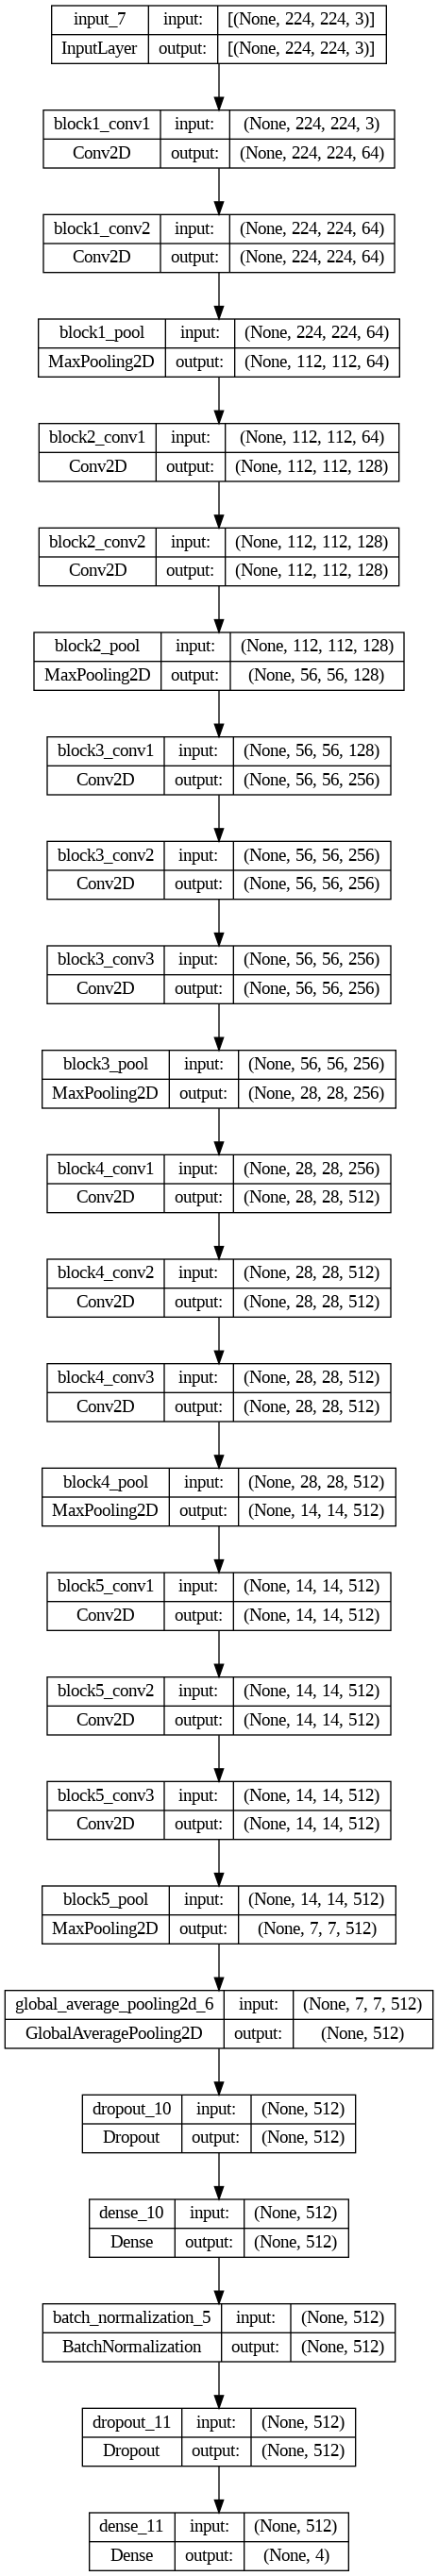

In [34]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow_addons.optimizers import RectifiedAdam
from tensorflow.keras.regularizers import l2

def VGG16_trf_learning(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # for layer in base_model.layers:
    #     layer.trainable = False
    for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.42836444684347735)(x)
    # x = Dense(468, activation='relu')(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0015))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1738378872651296)(x)

    output = Dense(num_classes, activation='softmax', dtype='float64', kernel_regularizer=l2(0.1))(x)

    model = Model(inputs=base_model.input, outputs=output)

    learning_rate = 0.0001
    radam = RectifiedAdam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=radam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 4

# Create the model
model = VGG16_trf_learning(input_shape, num_classes)

# Display the model summary
model.summary()

# You can plot the model to visualize the architecture
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


In [35]:
from keras.callbacks import *

# Define callbacks
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=200,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/200
24/24 [==============================] - ETA: 0s - loss: 3.4256 - accuracy: 0.2656 - categorical_accuracy: 0.2656 - precision_5: 0.2881 - recall_5: 0.1771
Epoch 1: val_loss improved from inf to 2.92646, saving model to ./models/vg16_trf_learning.keras
24/24 [==============================] - 10s 323ms/step - loss: 3.4256 - accuracy: 0.2656 - categorical_accuracy: 0.2656 - precision_5: 0.2881 - recall_5: 0.1771 - val_loss: 2.9265 - val_accuracy: 0.4167 - val_categorical_accuracy: 0.4167 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/200
24/24 [==============================] - ETA: 0s - loss: 3.4248 - accuracy: 0.2448 - categorical_accuracy: 0.2448 - precision_5: 0.2544 - recall_5: 0.1510
Epoch 2: val_loss improved from 2.92646 to 2.86039, saving model to ./models/vg16_trf_learning.keras
24/24 [==============================] - 8s 327ms/step - loss: 3.4248 - accuracy: 0.2448 - categorical_accuracy: 0.2448 - precision_5: 0.2544 - recall_5: 0

# Testing the Model

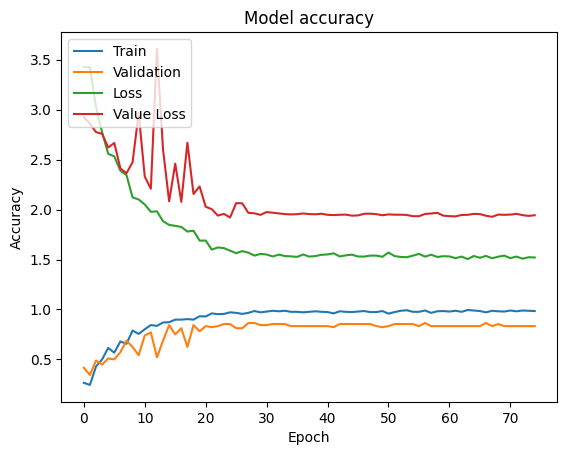

In [36]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

In [74]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)


# Predict and Display image using matplotlib
# plt.figure(figsize=(20, 20))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         # Print Class
#         plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

#         plt.imshow(image)
#         break


6/6 [==============================] - 1s 75ms/step - loss: 1.9204 - accuracy: 0.8542 - categorical_accuracy: 0.8542 - precision_5: 0.8913 - recall_5: 0.8542


[1.9204177856445312,
 0.8541666865348816,
 0.8541666865348816,
 0.8913043737411499,
 0.8541666865348816]

# Model Visualisation (Evaluation)

6/6 [==============================] - 0s 73ms/step


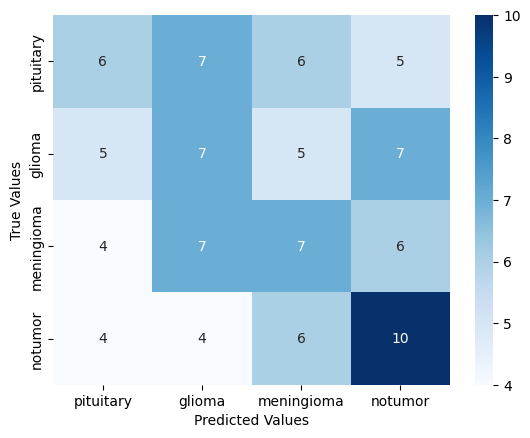

In [70]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Predict the output
predictions = model.predict(test_generator)
predictions = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_generator.classes, predictions)
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Values')
plt.ylabel('True Values');


In [71]:
from sklearn.metrics import confusion_matrix, accuracy_score

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Usage:
dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")

DSC: 0.31026652610954936, Sensitivity: 0.31250000000000006, Specificity: 0.7708333333333333, Accuracy: 0.3125


# KFolds

In [77]:
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import Flatten, Dense, Dropout, BatchNormalization
from keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import KFold
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import os

# Assuming 'dir' is your dataset directory
# Assuming 'model_file' is the path to your saved model file
# Assuming 'classes' is the list of class names

# Hyperparameters from the best trial
best_trial = {'dense_units': 665, 'dropout_rate': 0.2789232912960216, 'learning_rate': 3.666750519660056e-05}
best_dense_units = best_trial['dense_units']
best_dropout_rate = best_trial['dropout_rate']
best_learning_rate = best_trial['learning_rate']

def VGG16_trf_learning(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)


    for layer in base_model.layers[-4:]:  # Unfreeze the last 4 layers
        layer.trainable = True

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.42836444684347735)(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.0015))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.1738378872651296)(x)

    output = Dense(num_classes, activation='softmax', dtype='float64', kernel_regularizer=l2(0.1))(x)

    model = Model(inputs=base_model.input, outputs=output)

    learning_rate = 0.0001
    radam = RectifiedAdam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=radam,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'categorical_accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

    return model

# Data generators
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    # validation_split=0.2
)

# Load all data to split it manually
data_generator = datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

X = np.zeros((data_generator.samples, 224, 224, 3))
y = np.zeros((data_generator.samples, len(data_generator.class_indices)))

for i in range(data_generator.samples):
    X[i], y[i] = data_generator.next()

# K-Fold Cross Validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
val_scores = []

for train_index, val_index in kfold.split(X, y):
    print(f'Training fold {fold_no}...')

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    train_generator = datagen.flow(X_train, y_train, batch_size=16)
    val_generator = datagen.flow(X_val, y_val, batch_size=16)

    model = VGG16_trf_learning((224, 224, 3), len(classes))

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

    history = model.fit(
        train_generator,
        steps_per_epoch=len(X_train) // train_generator.batch_size,
        epochs=50,
        validation_data=val_generator,
        validation_steps=len(X_val) // val_generator.batch_size,
        callbacks=[early_stopping, reduce_lr]
    )

    loss, accuracy, _, _, _ = model.evaluate(val_generator)
    val_scores.append(accuracy)

    print(f'Validation accuracy for fold {fold_no}: {accuracy}')

    fold_no += 1

average_val_accuracy = np.mean(val_scores)
print(f'Average validation accuracy across all folds: {average_val_accuracy}')


Found 480 images belonging to 4 classes.
Training fold 1...
Epoch 1/50
24/24 [==============================] - 13s 373ms/step - loss: 3.3963 - accuracy: 0.2344 - categorical_accuracy: 0.2344 - precision_12: 0.2488 - recall_12: 0.1328 - val_loss: 3.0015 - val_accuracy: 0.2396 - val_categorical_accuracy: 0.2396 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
24/24 [==============================] - 7s 289ms/step - loss: 3.3139 - accuracy: 0.2812 - categorical_accuracy: 0.2812 - precision_12: 0.2843 - recall_12: 0.1458 - val_loss: 2.9924 - val_accuracy: 0.2396 - val_categorical_accuracy: 0.2396 - val_precision_12: 0.0000e+00 - val_recall_12: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/50
24/24 [==============================] - 8s 318ms/step - loss: 3.4433 - accuracy: 0.2292 - categorical_accuracy: 0.2292 - precision_12: 0.2205 - recall_12: 0.1120 - val_loss: 2.9607 - val_accuracy: 0.2708 - val_categorical_accuracy: 0.2708 - val_precision_12: 0.0000e+00 - v